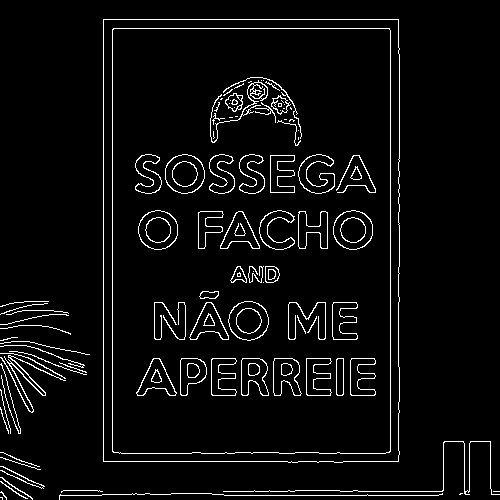

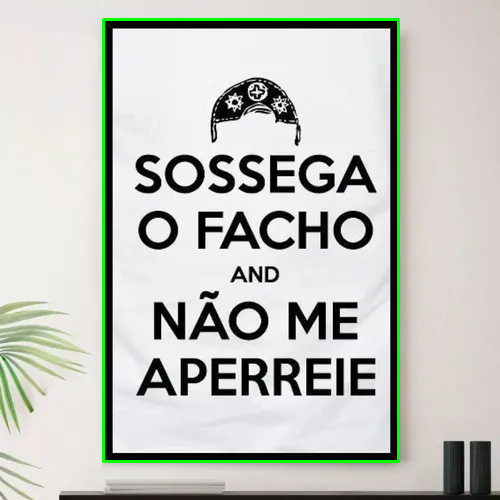

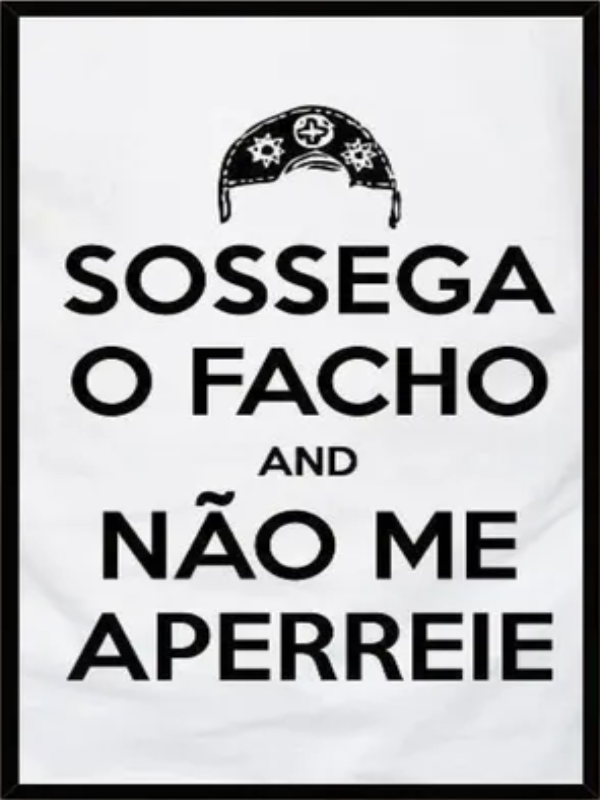

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Função para ordenar os pontos
def ordenar_pontos(pontos):
    pontos = pontos.reshape(4, 2)
    soma = pontos.sum(axis=1)
    dif = np.diff(pontos, axis=1)

    ordenados = np.zeros((4, 2), dtype="float32")
    ordenados[0] = pontos[np.argmin(soma)]       # topo-esquerda
    ordenados[2] = pontos[np.argmax(soma)]       # base-direita
    ordenados[1] = pontos[np.argmin(dif)]        # topo-direita
    ordenados[3] = pontos[np.argmax(dif)]        # base-esquerda
    return ordenados

# Carregar a imagem
image = cv2.imread("/content/D_NQ_NP_957564-MLB54275666155_032023-O.webp")
orig = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Pré-processamento
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)  # Parâmetros ajustados

# Mostrar bordas para debug
cv2_imshow(edges)

# Encontrar contornos
contornos, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contornos = sorted(contornos, key=cv2.contourArea, reverse=True)

doc_cnt = None

# Verificar contornos
for c in contornos:
    perimetro = cv2.arcLength(c, True)
    aprox = cv2.approxPolyDP(c, 0.02 * perimetro, True)
    if len(aprox) == 4:
        doc_cnt = aprox
        break

if doc_cnt is None:
    print("Não foi possível detectar automaticamente o documento.")
else:
    # Mostrar contorno detectado na imagem original
    imagem_contorno = orig.copy()
    cv2.drawContours(imagem_contorno, [doc_cnt], -1, (0, 255, 0), 2)
    cv2_imshow(imagem_contorno)

    # Ordenar pontos e transformar
    pts_orig = ordenar_pontos(doc_cnt)
    width, height = 600, 800
    pts_dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(pts_orig, pts_dst)
    warp = cv2.warpPerspective(orig, M, (width, height))

    # Mostrar imagem final corrigida
    cv2_imshow(warp)
